<a href="https://colab.research.google.com/github/Saransh-git/PredictingChurn/blob/master/child-electrical/DataAugmentation_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2  # reload changes to loaded module
%matplotlib inline

In [0]:
# Installing the packages
import pandas as pd 
import numpy as np
from fastai import *
from fastai.vision import *
from matplotlib import pyplot as plt

In [0]:
sq_tfms = ([
     RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.6, 0.75)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
     RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.7, 0.8)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), 
     RandTransform(tfm=TfmPixel (dihedral), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True), 
     RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), 
     RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
], get_transforms()[1])

In [6]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

#Defining the root directory to use the urls text
root_dir = 'gdrive/Shared drives/Fellowship.ai Chicago/'
base_path=Path(root_dir)
base_search_path=Path(root_dir + 'multi-class-images/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
 #Defining the base directory to save the folder 
np.random.seed(42)

data = ImageDataBunch.from_folder(
    base_search_path, train=".", valid_pct=0.2, ds_tfms=sq_tfms, size=(224,224),num_workers=3, resize_method=ResizeMethod.SQUISH, padding_mode='zeros'
).normalize(imagenet_stats)  # number of workers same as number of classes we have

In [0]:
np.random.seed(42)

data_wt = ImageDataBunch.from_folder(base_search_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224,num_workers=3).normalize(imagenet_stats)  # number of workers same as number of classes we have

In [0]:
#inds = np.random.random_integers(0, len(data.train_ds), 9)

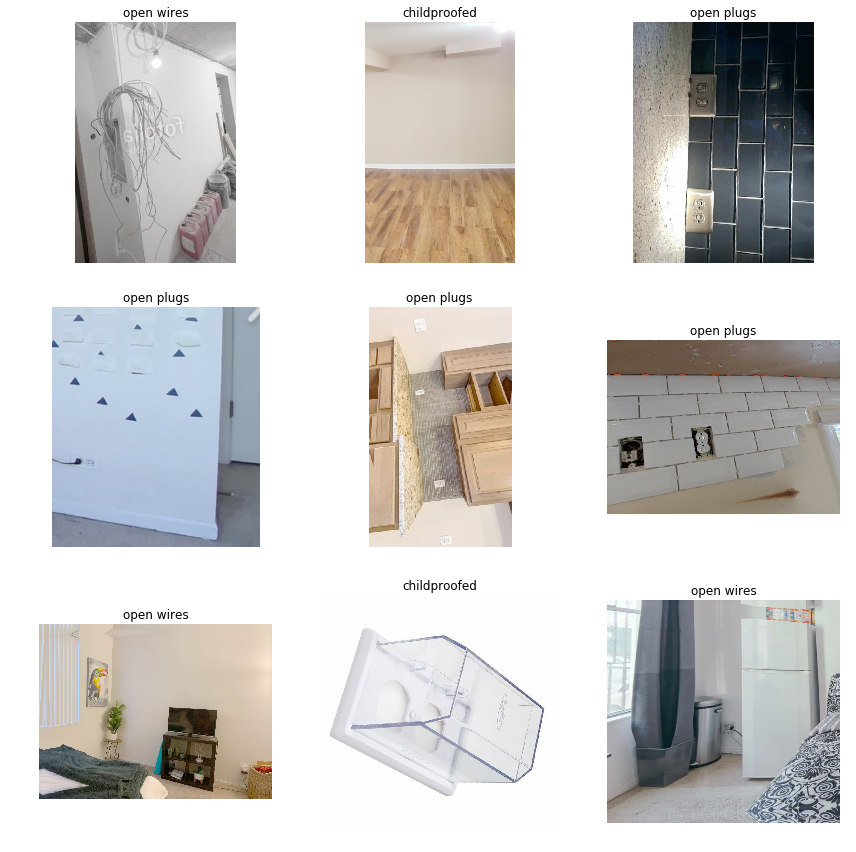

In [0]:
data.train_ds.show_xys(list(map(lambda r: r.apply_tfms(sq_tfms[0]), data.train_ds.x[inds])), data.train_ds.y[inds])

In [11]:
learn_initial = cnn_learner(data_wt, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 93.5MB/s]


In [0]:
learn_initial.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03
Min loss divided by 10: 5.75E-03


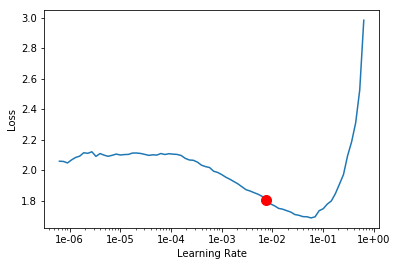

In [0]:
learn_initial.recorder.plot(suggestion=True)

In [8]:
learn_initial.fit_one_cycle(10, max_lr=slice(7.59e-04, 7.59e-03))

epoch,train_loss,valid_loss,error_rate,time
0,1.483827,1.073654,0.383817,08:47
1,1.239440,1.015318,0.356846,01:52
2,1.054643,0.793131,0.317427,01:52
3,0.899676,0.763701,0.255187,01:52
4,0.802729,0.698939,0.300830,01:54
5,0.709682,0.685673,0.265560,01:52
6,0.619253,0.666495,0.261411,01:51
7,0.536931,0.627200,0.240664,01:53
8,0.475750,0.626547,0.251037,01:54
9,0.430329,0.620880,0.248963,01:54


In [0]:
learn_initial.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.91E-07


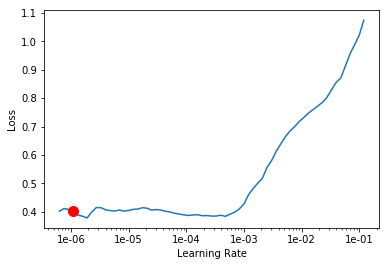

In [10]:
learn_initial.lr_find()
learn_initial.recorder.plot(suggestion=True)

In [11]:
learn_initial.fit_one_cycle(10, max_lr=slice(1.10e-07, 1.10e-06))

epoch,train_loss,valid_loss,error_rate,time
0,0.394931,0.626798,0.253112,01:55
1,0.394581,0.625806,0.253112,01:55
2,0.390371,0.625735,0.251037,01:55
3,0.392369,0.628423,0.253112,01:54
4,0.392300,0.628317,0.244813,01:55
5,0.372831,0.623745,0.253112,01:55
6,0.378672,0.618473,0.248963,01:56
7,0.383619,0.622692,0.253112,01:56
8,0.393048,0.619990,0.248963,01:56
9,0.398077,0.618677,0.248963,01:56


In [0]:
#learn_initial.save('baseline-model-post-clean')

In [0]:
learn_initial.load('baseline-model-post-clean')

In [0]:
train_interp = ClassificationInterpretation.from_learner(learn_initial, ds_type=DatasetType.Train)
interp = ClassificationInterpretation.from_learner(learn_initial)

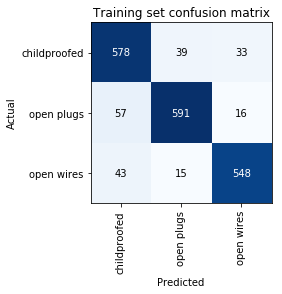

In [14]:
train_interp.plot_confusion_matrix(title='Training set confusion matrix')

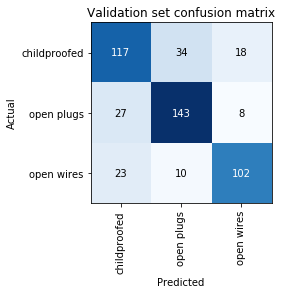

In [15]:
interp.plot_confusion_matrix(title='Validation set confusion matrix')

In [0]:
learn_wt = cnn_learner(data_wt, models.resnet34, metrics=error_rate)

In [0]:
learn_wt.fit_one_cycle(10, max_lr=slice(1.10e-03, 1.10e-02), wd=(1e-4, 1e-5, 1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,1.485283,1.088616,0.365145,01:58
1,1.244744,0.997701,0.375519,01:59
2,1.043464,0.900958,0.307054,01:57
3,0.947383,0.928028,0.319502,01:59
4,0.834847,0.766043,0.304979,01:56
5,0.732586,0.776116,0.267635,01:56
6,0.642770,0.678336,0.261411,01:56
7,0.552252,0.661390,0.224066,01:57
8,0.485957,0.631791,0.242739,01:54
9,0.438001,0.621798,0.244813,01:55


In [0]:
learn_wt.fit_one_cycle(4, max_lr=slice(1e-3), wd=0, moms=(0, 0))

epoch,train_loss,valid_loss,error_rate,time
0,0.361525,0.626472,0.242739,01:59
1,0.395198,0.624670,0.232365,01:56
2,0.389405,0.613351,0.228216,01:54
3,0.375008,0.610778,0.232365,01:55


In [0]:
learn_wt.unfreeze()

In [0]:
learn_wt.fit_one_cycle(6, max_lr=slice(1e-3), wd=0, moms=(0, 0))

epoch,train_loss,valid_loss,error_rate,time
0,0.340959,0.715667,0.230290,02:00
1,0.407315,0.752084,0.267635,01:59
2,0.363255,0.589109,0.213693,01:59
3,0.296822,0.608556,0.226141,01:58
4,0.237195,0.568919,0.205394,01:59
5,0.186552,0.581738,0.211618,02:01


In [0]:
#learn_wt.save('baseline-model-post-optimization')

In [17]:
learn_wt.load('baseline-model-post-optimization')
''

''

In [0]:
train_interp = ClassificationInterpretation.from_learner(learn_wt, ds_type=DatasetType.Train)
interp = ClassificationInterpretation.from_learner(learn_wt)

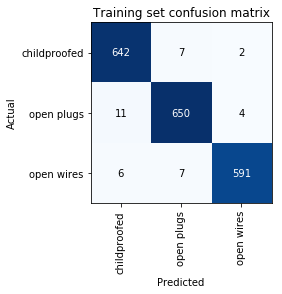

In [21]:
train_interp.plot_confusion_matrix(title='Training set confusion matrix')

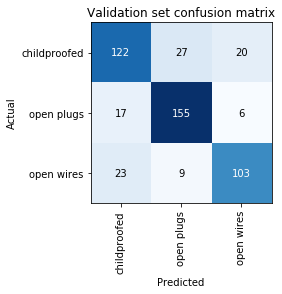

In [22]:
interp.plot_confusion_matrix(title='Validation set confusion matrix')

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(10, max_lr=slice(1.10e-03, 1.10e-02), wd=(1e-4, 1e-5, 1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,1.595432,1.113813,0.394191,05:30
1,1.396351,1.135550,0.443983,01:53
2,1.199155,0.971398,0.375519,01:51
3,1.066631,0.891482,0.394191,01:51
4,0.976522,0.863210,0.340249,01:52
5,0.877565,0.751374,0.290456,01:51
6,0.789317,0.659737,0.288382,01:52
7,0.693055,0.690423,0.286307,01:53
8,0.619193,0.660994,0.278008,01:52
9,0.586944,0.655242,0.284232,01:53


In [0]:
learn.fit_one_cycle(8, max_lr=slice(1e-3), wd=0, moms=(0, 0))

epoch,train_loss,valid_loss,error_rate,time
0,0.502691,0.649634,0.275934,01:54
1,0.521715,0.645838,0.280083,01:53
2,0.529850,0.653897,0.273859,01:53
3,0.507097,0.644181,0.271784,01:56
4,0.510731,0.637527,0.269710,01:54
5,0.489813,0.633946,0.269710,01:53
6,0.479657,0.631618,0.263485,01:55
7,0.485466,0.636723,0.267635,01:54


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(9, max_lr=slice(1e-3), wd=0, moms=(0, 0))

epoch,train_loss,valid_loss,error_rate,time
0,0.490037,0.639407,0.271784,01:56
1,0.521306,0.686781,0.296681,01:54
2,0.501362,0.640991,0.253112,01:58
3,0.454948,0.697181,0.257261,01:56
4,0.394936,0.593672,0.209544,01:55
5,0.340276,0.559928,0.209544,01:56
6,0.303601,0.540823,0.213693,01:56
7,0.254931,0.509914,0.188797,01:52
8,0.209338,0.508570,0.188797,01:55
9,0.182774,0.517925,0.192946,01:56


In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-3), wd=0, moms=(0, 0))

epoch,train_loss,valid_loss,error_rate,time
0,0.177151,0.691765,0.238589,01:56
1,0.233514,0.735116,0.240664,01:56
2,0.218921,0.561226,0.186722,01:59
3,0.187451,0.527077,0.176349,01:54


In [0]:
#learn.save('data-augmentation-squish')

In [0]:
learn.load('data-augmentation-squish')

In [0]:
train_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)
interp = ClassificationInterpretation.from_learner(learn)

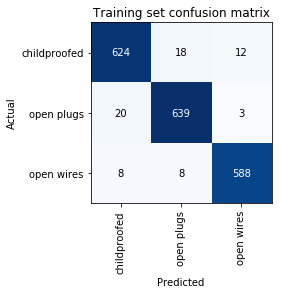

In [28]:
train_interp.plot_confusion_matrix(title='Training set confusion matrix')

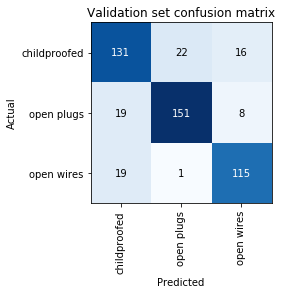

In [29]:
interp.plot_confusion_matrix(title='Validation set confusion matrix')